In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization
from keras.layers.core import Lambda
from keras.models import Model , load_model

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


## Carga y distribución de datos

In [2]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])
    Logg = np.array(F['NN_Logg'])

In [3]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [4]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra, axis = 2)
Y = np.expand_dims(parallax, axis = 1)
K_mag = np.expand_dims(Kmag, axis = 1)

# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag)
Gmag_mean = np.mean(Gmag)
Gmag_norm = (Gmag - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
bp_rp_norm = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
teff_norm = (teff - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)
teff_not_norm = np.expand_dims(teff, axis=1)
G_mag_not_norm = np.expand_dims(Gmag, axis=1)
Log_g= np.expand_dims(Logg, axis=1)
G_BP_RP = np.expand_dims(bp_rp, axis=1)

X_offset = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1) 

In [5]:
print(X.shape , Y.shape, K_mag.shape, X_offset.shape)

(60986, 7514, 1) (60986, 1) (60986, 1) (60986, 3)


#### SNR cut

In [6]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr)):
    if snr[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(10)
random.shuffle(high_snr_idx)
random.seed(60)
random.shuffle(low_snr_idx)

#### Estos valores pueden ser comparados con Bovy train-test separation, 

Apart from taht we should be more clear about data preparation and evaluation

get consistent and repeatable accuracy using train and validation approach <br>
undestand the process of validation (draft about probability_distributions) <br> 
check the precision on the test data using baseline separation <br>
compute learning curve, following Fig 1. of Nguyen et. al.<br>
try with percentual mse, such that low and high parallax values weight the same <br>

initially we can consider SNR>200 for train-valid and SNR<200 for test <br>
understand why it is possible to make this separation and hope for consistent results <br>

compare to Bovy using this data separation, using global precision and learning curve<br>

How well are we doing with respect to Bovy?

In [7]:
#Image("/home/bapanes/Research-Now/TesisAnell/Figures/learning_curve_genoma.png")
#Image("learning_curve_genoma.png")

In [8]:
print("SNR>200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR>200: 27721, else: 33265


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  177 (train) + 44 (valid) = 221

train_val_2 $\rightarrow$  400 (train) + 100 (valid) = 500

train_val_3 $\rightarrow$  800 (train) + 200 (valid) = 1000

train_val_4 $\rightarrow$  2400 (train) + 600 (valid) = 3000

train_val_5 $\rightarrow$  6400 (train) + 1600 (valid) = 8000

train_val_6 $\rightarrow$  12000 (train) + 3000 (valid) = 15000

train_val_7 $\rightarrow$  22177 (train) + 5594 (valid) = 27721

test $\rightarrow$ 33265

In [9]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_high_snr = X_offset[high_snr_idx]
#teff_not_norm_high_snr = teff_not_norm[high_snr_idx]

X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_low_snr = X_offset[low_snr_idx]
#teff_not_norm_low_snr = teff_not_norm[low_snr_idx]

In [10]:
X_train_val_1 = X_high_snr[:221]
Y_train_val_1 = Y_high_snr[:221]
K_mag_train_val_1 = K_mag_high_snr[:221]
X_offset_train_val_1 = X_offset_high_snr[:221]

X_train_val_2 = X_high_snr[221:721]
Y_train_val_2 = Y_high_snr[221:721]
K_mag_train_val_2 = K_mag_high_snr[221:721]
X_offset_train_val_2 = X_offset_high_snr[221:721]

X_train_val_3 = X_high_snr[721:1721]
Y_train_val_3 = Y_high_snr[721:1721]
K_mag_train_val_3 = K_mag_high_snr[721:1721]
X_offset_train_val_3 = X_offset_high_snr[721:1721]

X_train_val_4 = X_high_snr[1721:4721]
Y_train_val_4 = Y_high_snr[1721:4721]
K_mag_train_val_4 = K_mag_high_snr[1721:4721]
X_offset_train_val_4 = X_offset_high_snr[1721:4721]

X_train_val_5 = X_high_snr[4721:12721]
Y_train_val_5 = Y_high_snr[4721:12721]
K_mag_train_val_5 = K_mag_high_snr[4721:12721]
X_offset_train_val_5 = X_offset_high_snr[4721:12721]

X_train_val_6 = X_high_snr[12721:]
Y_train_val_6 = Y_high_snr[12721:]
K_mag_train_val_6 = K_mag_high_snr[12721:]
X_offset_train_val_6 = X_offset_high_snr[12721:]

X_train_val_7 = X_high_snr
Y_train_val_7 = Y_high_snr
K_mag_train_val_7 = K_mag_high_snr
X_offset_train_val_7 = X_offset_high_snr

X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_test = X_offset_low_snr
snr_test = snr[low_snr_idx]
teff_test = teff_not_norm[low_snr_idx]
G_mag_test = G_mag_not_norm[low_snr_idx]
logg_test = Log_g[low_snr_idx]
G_bp_rp_test = G_BP_RP[low_snr_idx]

In [11]:
print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , 
      Y_train_val_5.shape,Y_train_val_6.shape ,Y_train_val_7.shape , Y_test.shape)

(221, 1) (500, 1) (1000, 1) (3000, 1) (8000, 1) (15000, 1) (27721, 1) (33265, 1)


## Carga de modelos

In [12]:
path_local_models = '/home/anell/Desktop/Bovy/AnellExercises/Good_Models/'

#No consideraré los modelos 1 y 2 porque se entrenaron con muy pocos datos

model_3 = load_model(f'{path_local_models}/Modelo_1_200epoch_D3_ReplicaBovy.h5',custom_objects={'tf': tf}) #1000
model_4 = load_model(f'{path_local_models}/Modelo_1_200epoch_D4_ReplicaBovy.h5',custom_objects={'tf': tf}) #3000
model_5 = load_model(f'{path_local_models}/Modelo_1_200epoch_D5_ReplicaBovy.h5',custom_objects={'tf': tf}) #8000
model_6 = load_model(f'{path_local_models}/Modelo_1_200epoch_D6_ReplicaBovy.h5',custom_objects={'tf': tf}) #15000
model_7 = load_model(f'{path_local_models}/Modelo_1_200epoch_D7_ReplicaBovy.h5',custom_objects={'tf': tf}) #27771

### Separación según temperatura efectiva en set de testeo

In [13]:
min(teff_test) , max(teff_test)

(array([3647.6694], dtype=float32), array([5947.7134], dtype=float32))

In [17]:
teff_3000_4500 = []
teff_4500_5000 = []
teff_5000_5500 = []
teff_5500_6000 = []



for i in range(len(teff_test)):
    if teff_test[i] <= 4500:
        teff_3000_4500.append(i)
    elif 4500 < teff_test[i] <= 5000:
        teff_4500_5000.append(i)
    elif 5000 < teff_test[i] <= 5500:
        teff_5000_5500.append(i)
    else :
        teff_5500_6000.append(i)

print(len(teff_3000_4500),len(teff_4500_5000),len(teff_5000_5500),
      len(teff_5500_6000))

5265 13947 10781 3272


In [18]:
X_test_teff_3000_4500 = X_test[teff_3000_4500]
Y_test_teff_3000_4500 = Y_test[teff_3000_4500]
K_mag_test_teff_3000_4500 = K_mag_test[teff_3000_4500]
X_offset_test_teff_3000_4500 = X_offset_test[teff_3000_4500]
teff_test_teff_3000_4500 = teff_test[teff_3000_4500]
G_mag_test_snr_teff_3000_4500 = G_mag_test[teff_3000_4500]
logg_test_snr_teff_3000_4500 = logg_test[teff_3000_4500]
G_bp_rp_test_snr_teff_3000_4500 = G_bp_rp_test[teff_3000_4500]

X_test_teff_4500_5000 = X_test[teff_4500_5000]
Y_test_teff_4500_5000 = Y_test[teff_4500_5000]
K_mag_test_teff_4500_5000 = K_mag_test[teff_4500_5000]
X_offset_test_teff_4500_5000 = X_offset_test[teff_4500_5000]
teff_test_teff_4500_5000 = teff_test[teff_4500_5000]
G_mag_test_snr_teff_4500_5000 = G_mag_test[teff_4500_5000]
logg_test_snr_teff_4500_5000 = logg_test[teff_4500_5000]
G_bp_rp_test_snr_teff_4500_5000 = G_bp_rp_test[teff_4500_5000]

X_test_teff_5000_5500 = X_test[teff_5000_5500]
Y_test_teff_5000_5500 = Y_test[teff_5000_5500]
K_mag_test_teff_5000_5500 = K_mag_test[teff_5000_5500]
X_offset_test_teff_5000_5500 = X_offset_test[teff_5000_5500]
teff_test_teff_5000_5500 = teff_test[teff_5000_5500]
G_mag_test_snr_teff_5000_5500 = G_mag_test[teff_5000_5500]
logg_test_snr_teff_5000_5500 = logg_test[teff_5000_5500]
G_bp_rp_test_snr_teff_5000_5500 = G_bp_rp_test[teff_5000_5500]

X_test_teff_5500_6000 = X_test[teff_5500_6000]
Y_test_teff_5500_6000 = Y_test[teff_5500_6000]
K_mag_test_teff_5500_6000 = K_mag_test[teff_5500_6000]
X_offset_test_teff_5500_6000 = X_offset_test[teff_5500_6000]
teff_test_teff_5500_6000 = teff_test[teff_5500_6000]
G_mag_test_snr_teff_5500_6000 = G_mag_test[teff_5500_6000]
logg_test_snr_teff_5500_6000 = logg_test[teff_5500_6000]
G_bp_rp_test_snr_teff_5500_6000 = G_bp_rp_test[teff_5500_6000]

print(Y_test_teff_3000_4500.shape, Y_test_teff_4500_5000.shape, 
      Y_test_teff_5000_5500.shape, Y_test_teff_5500_6000.shape)

(5265, 1) (13947, 1) (10781, 1) (3272, 1)


### Curva de aprendizaje MAD en función a temperatura

In [19]:
def MAD(Y,Y_hat):  
    R_percent = (Y - Y_hat) / Y *100
    s_mad = 1.4826 * np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

In [22]:
Y_hat_m7_teff_3000_4500 = model_7.predict([X_test_teff_3000_4500,K_mag_test_teff_3000_4500,X_offset_test_teff_3000_4500])
Y_hat_m7_teff_4500_5000 = model_7.predict([X_test_teff_4500_5000,K_mag_test_teff_4500_5000,X_offset_test_teff_4500_5000])
Y_hat_m7_teff_5000_5500 = model_7.predict([X_test_teff_5000_5500,K_mag_test_teff_5000_5500,X_offset_test_teff_5000_5500])
Y_hat_m7_teff_5500_6000 = model_7.predict([X_test_teff_5500_6000,K_mag_test_teff_5500_6000,X_offset_test_teff_5500_6000])

mad_m7_teff_3000_4500 = MAD(Y_test_teff_3000_4500, Y_hat_m7_teff_3000_4500)
mad_m7_teff_4500_5000 = MAD(Y_test_teff_4500_5000, Y_hat_m7_teff_4500_5000)
mad_m7_teff_5000_5500 = MAD(Y_test_teff_5000_5500, Y_hat_m7_teff_5000_5500)
mad_m7_teff_5500_6000 = MAD(Y_test_teff_5500_6000, Y_hat_m7_teff_5500_6000)


mad_test_m7_teff = [mad_m7_teff_3000_4500 , mad_m7_teff_4500_5000 ,
                  mad_m7_teff_5000_5500 , mad_m7_teff_5500_6000]

print("mad's modelo 7: ", mad_test_m7_teff) 

mad's modelo 7:  [13.241405711797153, 14.627426699947128, 14.32888384959681, 14.833497754511304]


In [24]:
Y_hat_m6_teff_3000_4500 = model_6.predict([X_test_teff_3000_4500,K_mag_test_teff_3000_4500,X_offset_test_teff_3000_4500])
Y_hat_m6_teff_4500_5000 = model_6.predict([X_test_teff_4500_5000,K_mag_test_teff_4500_5000,X_offset_test_teff_4500_5000])
Y_hat_m6_teff_5000_5500 = model_6.predict([X_test_teff_5000_5500,K_mag_test_teff_5000_5500,X_offset_test_teff_5000_5500])
Y_hat_m6_teff_5500_6000 = model_6.predict([X_test_teff_5500_6000,K_mag_test_teff_5500_6000,X_offset_test_teff_5500_6000])

mad_m6_teff_3000_4500 = MAD(Y_test_teff_3000_4500, Y_hat_m6_teff_3000_4500)
mad_m6_teff_4500_5000 = MAD(Y_test_teff_4500_5000, Y_hat_m6_teff_4500_5000)
mad_m6_teff_5000_5500 = MAD(Y_test_teff_5000_5500, Y_hat_m6_teff_5000_5500)
mad_m6_teff_5500_6000 = MAD(Y_test_teff_5500_6000, Y_hat_m6_teff_5500_6000)


mad_test_m6_teff = [mad_m6_teff_3000_4500 , mad_m6_teff_4500_5000 ,
                   mad_m6_teff_5000_5500 , mad_m6_teff_5500_6000]

print("mad's modelo 6: ", mad_test_m6_teff) 

mad's modelo 6:  [15.163648464893534, 15.231785247319138, 15.366968424603478, 15.249510010211882]


In [25]:
Y_hat_m5_teff_3000_4500 = model_5.predict([X_test_teff_3000_4500,K_mag_test_teff_3000_4500,X_offset_test_teff_3000_4500])
Y_hat_m5_teff_4500_5000 = model_5.predict([X_test_teff_4500_5000,K_mag_test_teff_4500_5000,X_offset_test_teff_4500_5000])
Y_hat_m5_teff_5000_5500 = model_5.predict([X_test_teff_5000_5500,K_mag_test_teff_5000_5500,X_offset_test_teff_5000_5500])
Y_hat_m5_teff_5500_6000 = model_5.predict([X_test_teff_5500_6000,K_mag_test_teff_5500_6000,X_offset_test_teff_5500_6000])

mad_m5_teff_3000_4500 = MAD(Y_test_teff_3000_4500, Y_hat_m5_teff_3000_4500)
mad_m5_teff_4500_5000 = MAD(Y_test_teff_4500_5000, Y_hat_m5_teff_4500_5000)
mad_m5_teff_5000_5500 = MAD(Y_test_teff_5000_5500, Y_hat_m5_teff_5000_5500)
mad_m5_teff_5500_6000 = MAD(Y_test_teff_5500_6000, Y_hat_m5_teff_5500_6000)


mad_test_m5_teff = [mad_m5_teff_3000_4500 , mad_m5_teff_4500_5000 ,
                   mad_m5_teff_5000_5500 , mad_m5_teff_5500_6000]

print("mad's modelo 5: ", mad_test_m5_teff)

mad's modelo 5:  [18.778361005362598, 20.563926507788658, 20.243397335912963, 19.478283113352]


In [26]:
Y_hat_m4_teff_3000_4500 = model_4.predict([X_test_teff_3000_4500,K_mag_test_teff_3000_4500,X_offset_test_teff_3000_4500])
Y_hat_m4_teff_4500_5000 = model_4.predict([X_test_teff_4500_5000,K_mag_test_teff_4500_5000,X_offset_test_teff_4500_5000])
Y_hat_m4_teff_5000_5500 = model_4.predict([X_test_teff_5000_5500,K_mag_test_teff_5000_5500,X_offset_test_teff_5000_5500])
Y_hat_m4_teff_5500_6000 = model_4.predict([X_test_teff_5500_6000,K_mag_test_teff_5500_6000,X_offset_test_teff_5500_6000])

mad_m4_teff_3000_4500 = MAD(Y_test_teff_3000_4500, Y_hat_m4_teff_3000_4500)
mad_m4_teff_4500_5000 = MAD(Y_test_teff_4500_5000, Y_hat_m4_teff_4500_5000)
mad_m4_teff_5000_5500 = MAD(Y_test_teff_5000_5500, Y_hat_m4_teff_5000_5500)
mad_m4_teff_5500_6000 = MAD(Y_test_teff_5500_6000, Y_hat_m4_teff_5500_6000)


mad_test_m4_teff = [mad_m4_teff_3000_4500 , mad_m4_teff_4500_5000 ,
                    mad_m4_teff_5000_5500 , mad_m4_teff_5500_6000]

print("mad's modelo 4: ", mad_test_m4_teff)

mad's modelo 4:  [20.200940676135474, 23.101123938442285, 22.52398199096302, 22.492345504095937]


In [27]:
Y_hat_m3_teff_3000_4500 = model_3.predict([X_test_teff_3000_4500,K_mag_test_teff_3000_4500,X_offset_test_teff_3000_4500])
Y_hat_m3_teff_4500_5000 = model_3.predict([X_test_teff_4500_5000,K_mag_test_teff_4500_5000,X_offset_test_teff_4500_5000])
Y_hat_m3_teff_5000_5500 = model_3.predict([X_test_teff_5000_5500,K_mag_test_teff_5000_5500,X_offset_test_teff_5000_5500])
Y_hat_m3_teff_5500_6000 = model_3.predict([X_test_teff_5500_6000,K_mag_test_teff_5500_6000,X_offset_test_teff_5500_6000])

mad_m3_teff_3000_4500 = MAD(Y_test_teff_3000_4500, Y_hat_m3_teff_3000_4500)
mad_m3_teff_4500_5000 = MAD(Y_test_teff_4500_5000, Y_hat_m3_teff_4500_5000)
mad_m3_teff_5000_5500 = MAD(Y_test_teff_5000_5500, Y_hat_m3_teff_5000_5500)
mad_m3_teff_5500_6000 = MAD(Y_test_teff_5500_6000, Y_hat_m3_teff_5500_6000)


mad_test_m3_teff = [mad_m3_teff_3000_4500 , mad_m3_teff_4500_5000 ,
                    mad_m3_teff_5000_5500 , mad_m3_teff_5500_6000]

print("mad's modelo 3: ", mad_test_m3_teff)

mad's modelo 3:  [21.507825606386387, 26.001972896126528, 29.681313953348518, 25.81818822366104]


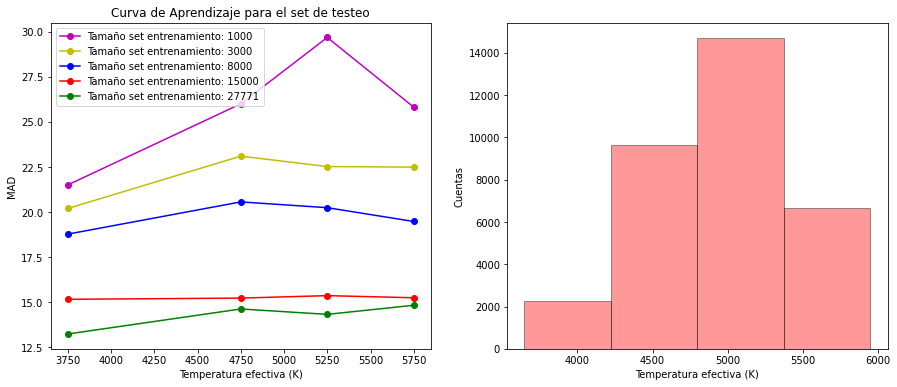

In [33]:
teff_list = [3750, 4750 , 5250 , 5750]

plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot(teff_list, mad_test_m3_teff, "om-", label = "Tamaño set entrenamiento: 1000")
plt.plot(teff_list, mad_test_m4_teff, "oy-", label = "Tamaño set entrenamiento: 3000")
plt.plot(teff_list, mad_test_m5_teff, "ob-", label = "Tamaño set entrenamiento: 8000")
plt.plot(teff_list, mad_test_m6_teff, "or-", label = "Tamaño set entrenamiento: 15000")
plt.plot(teff_list, mad_test_m7_teff, "og-", label = "Tamaño set entrenamiento: 27771")

plt.legend(loc= "upper left", bbox_to_anchor=(0, 1))
plt.ylabel("MAD")
#plt.yscale("log")
plt.xlabel("Temperatura efectiva (K)")
plt.title("Curva de Aprendizaje para el set de testeo")
#plt.ylim(0,80)


plt.subplot(1,2,2)
plt.hist(teff_test, bins=4, alpha=0.4 , color="r",edgecolor='k')
#plt.xlim([-500, 500])
plt.xlabel('Temperatura efectiva (K)')
plt.ylabel('Cuentas')
plt.show()